# Pre-processing

Explore possible pre-processing steps for time series.

In [1]:
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

## Load data

In [2]:
# Define file paths
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    data = './ctu-data_csv'
    meta = 'metadata.csv'


paths = Paths()

In [3]:
# Set up dictionary for CSV files
csv_files = dict()

filenames = os.listdir(paths.data) # 获取目录 paths.data 中的所有文件名
filenames.remove(paths.meta) # 从文件名列表中移除元数据文件（paths.meta）
for file in filenames:
    filename, file_extension = os.path.splitext(os.path.join(paths.data, file)) # 获取文件名（filename）和文件扩展名（file_extension）
    # Load data and save to dict with filename (without path/csv) as index
    if file_extension == '.csv':
        filename_short = filename.split(os.sep)[-1] # 使用 filename.split(os.sep)[-1] 获取文件名的最后一部分，即去掉路径后的文件名
        csv_files[filename_short] = pd.read_csv(os.path.join(paths.data, file))
print(csv_files.keys())

# Load meta data
metadata = pd.read_csv(os.path.join(paths.data, paths.meta),
                       index_col='parameter')

dict_keys(['1012', '1006', '1210', '1204', '2043', '1238', '1402', '1364', '1370', '1416', '1358', '1199', '1166', '1172', '1173', '1167', '1198', '1359', '1371', '1417', '1403', '1365', '1239', '2042', '1205', '1211', '1007', '1013', '1005', '1011', '1039', '1207', '1213', '2040', '1398', '1415', '1373', '1367', '1401', '1429', '1171', '1165', '1159', '1158', '1164', '1170', '1428', '1366', '1400', '1414', '1372', '1399', '2041', '1212', '1206', '1038', '1010', '1004', '1028', '1014', '2045', '1202', '1216', '1389', '1438', '1376', '1410', '1404', '1362', '1148', '1174', '1160', '1161', '1175', '1149', '1405', '1363', '1377', '1411', '1439', '1388', '1217', '1203', '2044', '1015', '1001', '1029', '1017', '1003', '1229', '2046', '1215', '1201', '1349', '1361', '1407', '1413', '1375', '1188', '1163', '1177', '1176', '1162', '1189', '1412', '1374', '1360', '1406', '1348', '1200', '1214', '1228', '1002', '1016', '1071', '1065', '1059', '1298', '1273', '1501', '2008', '1267', '2020', '2034

In [4]:
def plot_fhr(fhr):
    '''
    Plot fetal heartrate
    Input:
    - fhr - series, heartrate in bpm, each row represents a quarter of a second
    '''
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(fhr.index/(60*4), fhr) # 将索引转换为分钟。因为每行数据代表四分之一秒，所以索引需要除以 (60*4) 来转换为分钟
    ax.set_xlabel('Time (minutes)')
    ax.set_ylabel('FHR (bpm)')
    plt.show()

## FHR Cleaning Function

In [7]:
def clean_fhr(fhr, show_figure=False, mode='spline'):
    '''
    Cleans fetal heart rate (FHR) signal.
    Inputs:
    fhr - series, the "FHR" column from one of the csv files
    show_figure - boolean, whether to display the FHR before and after cleaning
    Outputs:
    fhr - series, clean version of the FHR column
    '''
    if show_figure: # 如果 show_figure 为 True，显示原始 FHR 信号图
        # Show original trace
        fig, ax = plt.subplots(figsize=(20, 5))
        ax.plot(fhr.index/(60*4), fhr)
        ax.set_xlabel('Time (minutes)')
        ax.set_ylabel('FHR (bpm)')
        ax.set_ylim(0, 200)
        ax.set_yticks(np.arange(0, 201, 20)) # 将 Y 轴的范围设置为 0 到 200，刻度间隔为 20
        plt.show()

    # Replace 0 with NaN
    fhr.replace(0, np.nan, inplace=True)

    # Remove NaN if they occured for more than 15 seconds consecutively
    na = fhr.isnull()
    fhr = fhr[~(fhr.groupby(na.ne(na.shift()).cumsum().values).transform('size').ge(61) & na)].reset_index(drop=True)

    # Replace missing values using linear interpolation
    fhr = fhr.interpolate(method='linear')

    # Find how each value has changed from the prior value
    diff = fhr - fhr.shift()

    # Where difference is more than +- 25, set as NaN
    fhr[(diff > 25) | (diff < -25)] = np.nan

    # Replace missing values using linear interpolation
    fhr = fhr.interpolate(method='linear')

    # Set outliers to NaN
    fhr[fhr < 50] = np.nan
    fhr[fhr > 200] = np.nan

    fhr = fhr.interpolate(method='cubic')

    if show_figure: # 显示清洗后的 FHR 信号图
        # Show clean trace
        fig, ax = plt.subplots(figsize=(20, 5))
        ax.plot(fhr.index/(60*4), fhr)
        ax.set_xlabel('Time (minutes)')
        ax.set_ylabel('FHR (bpm)')
        ax.set_ylim(0, 200)
        ax.set_yticks(np.arange(0, 201, 20))
        plt.show()

    return(fhr)

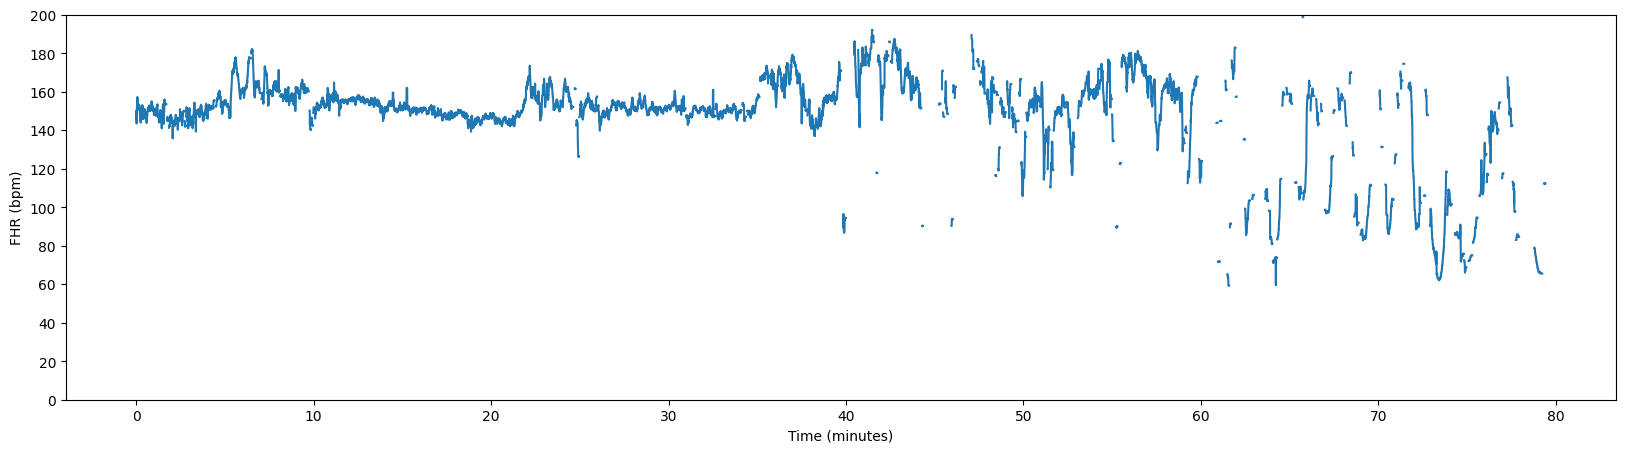

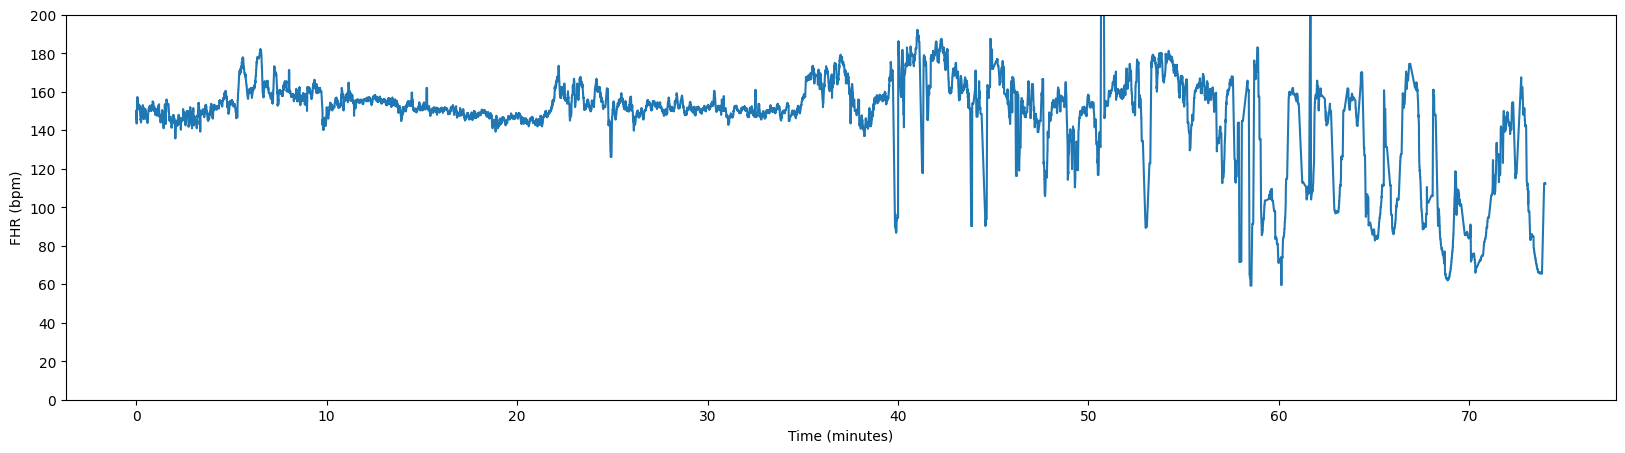

In [8]:
fhr_1002 = clean_fhr(csv_files['1002']['FHR'], show_figure=True)

## Apply FHR cleaning function to all signals

In [10]:
# Loop through all the csv file dataframes, apply cleaning and then save
for key, value in csv_files.items():
    df = clean_fhr(value['FHR'])
    df.to_csv(f'ctu-data_fhr_clean/{key}.csv', index=False)